# Week 3 - Saturday: FFT-based Deconvolution

This notebook explores image deconvolution using the Fast Fourier Transform (FFT). Deconvolution aims to reverse the effects of a blur, assuming the blur process can be modeled by a convolution with a Point Spread Function (PSF), also known as the blur kernel.

**Key Concepts:**
- **Convolution Theorem:** Convolution in the spatial domain is equivalent to element-wise multiplication in the frequency domain.
  $g(x,y) = f(x,y) * h(x,y) \iff G(u,v) = F(u,v) \cdot H(u,v)$
  where $g$ is the blurred image, $f$ is the original sharp image, $h$ is the blur kernel (PSF), and $G, F, H$ are their respective Fourier Transforms.
- **Deconvolution Goal:** Given $g$ and an estimate of $h$ (or $H$), recover an estimate of $f$ (or $F$).
  $\hat{F}(u,v) = G(u,v) / H(u,v)$ (Inverse Filtering)
- **Challenges:** Noise amplification, especially where $H(u,v)$ is small or zero.

**Methods to be Explored:**
1.  **Inverse Filtering:** Direct division in the frequency domain. Highly sensitive to noise and zeros in $H(u,v)$.
2.  **Wiener Filtering:** A more robust method that incorporates knowledge of noise and signal power spectra.

**Evaluation Metrics:**
- **Peak Signal-to-Noise Ratio (PSNR):** Measures the ratio between the maximum possible power of a signal and the power of corrupting noise that affects the fidelity of its representation. Higher is better.
- **Structural Similarity Index (SSIM):** Measures the similarity between two images, considering luminance, contrast, and structure. Ranges from -1 to 1, where 1 indicates perfect similarity.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d # For spatial convolution if needed
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import os

# --- Configuration & Output Directory ---
OUTPUT_DIR_NOTEBOOK = "output_week3_saturday_notebook"
os.makedirs(OUTPUT_DIR_NOTEBOOK, exist_ok=True)

# Matplotlib display helper
def display_imgs(img_dict, cols=3, main_title="Image Comparison", save_base_path=None):
    num_images = len(img_dict)
    rows = int(np.ceil(num_images / cols))
    fig_width = cols * 4
    fig_height = rows * 4 + (0.5 if main_title else 0)

    plt.figure(figsize=(fig_width, fig_height))
    if main_title:
        plt.suptitle(main_title, fontsize=16)
    
    filenames_map = {}
    for i, (title, img_data) in enumerate(img_dict.items()):
        plt.subplot(rows, cols, i + 1)
        
        # Handle different types of image data (spatial, spectrum)
        if isinstance(img_data, tuple) and len(img_data) == 2 and isinstance(img_data[1], str): # (image, type)
            img, img_type = img_data
        else:
            img, img_type = img_data, 'spatial' # Default to spatial
            
        if img is None:
            plt.title(title + "\n(N/A)")
            plt.axis('off')
            continue

        if img_type == 'spatial':
            if img.ndim == 3: # Color
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            else: # Grayscale
                plt.imshow(img, cmap='gray')
            plt.title(f"{title}\n{img.shape[1]}x{img.shape[0]}")
        elif img_type == 'spectrum':
            # Assumes magnitude spectrum, log-scaled and shifted
            plt.imshow(img_data[0], cmap='viridis') # img_data[0] is the spectrum image
            plt.title(f"{title}\n(Log Mag Spectrum)")
        
        plt.axis('off')

        if save_base_path:
            filename_part = title.lower().replace(" ", "_").replace("(", "").replace(")", "").replace("=", "").replace(",", "").replace("\n", "_").replace("/", "_")
            if len(filename_part) > 40: filename_part = filename_part[:40]
            full_save_path = os.path.join(OUTPUT_DIR_NOTEBOOK, f"{save_base_path}_{i}_{filename_part}.png")
            
            if img_type == 'spatial':
                cv2.imwrite(full_save_path, img)
            elif img_type == 'spectrum': # Save spectrum as an image
                # Normalize spectrum image for saving
                spec_to_save = img_data[0]
                spec_to_save = ((spec_to_save - spec_to_save.min()) / (spec_to_save.max() - spec_to_save.min() + 1e-6) * 255).astype(np.uint8)
                cv2.imwrite(full_save_path, spec_to_save)
            filenames_map[title] = full_save_path

    plt.tight_layout(rect=[0, 0, 1, 0.95 if main_title else 1])
    plt.show()
    if save_base_path:
        print("Saved images:")
        for title, path in filenames_map.items():
            print(f"- '{title}': {path}")
            
print("Setup complete.")

Setup complete.


## 1. Prepare Test Data: Original, Blur Kernel, Blurred Image, Noisy Blurred Image

We need:
- An original sharp image (grayscale for simplicity first).
- A blur kernel (Point Spread Function - PSF).
- A blurred version of the original image (by convolving with the PSF).
- A noisy version of the blurred image (to simulate real-world conditions).

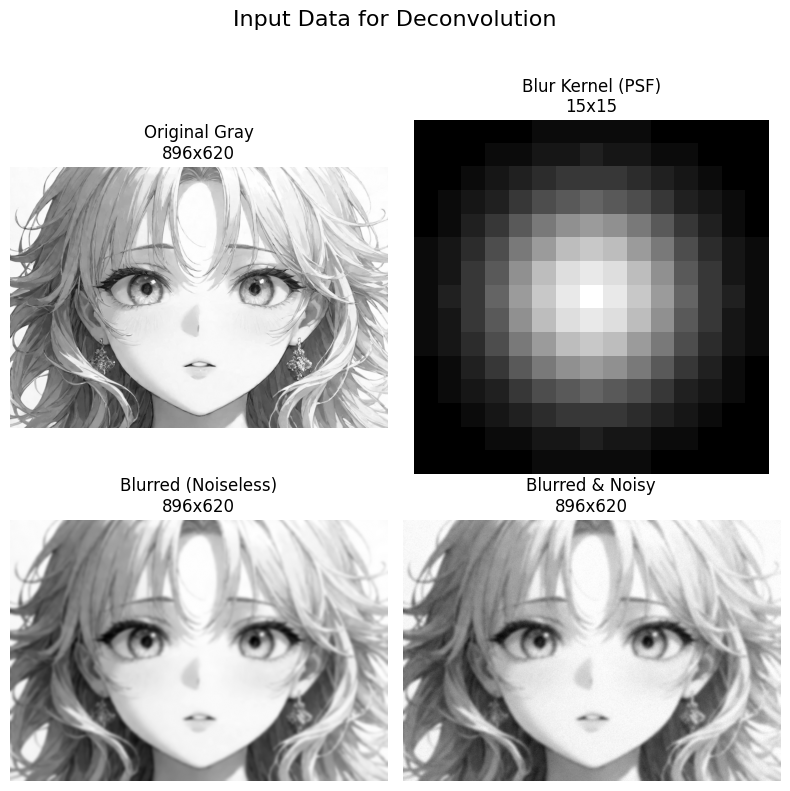

Saved images:
- 'Original Gray': output_week3_saturday_notebook/01_input_0_original_gray.png
- 'Blur Kernel (PSF)': output_week3_saturday_notebook/01_input_1_blur_kernel_psf.png
- 'Blurred (Noiseless)': output_week3_saturday_notebook/01_input_2_blurred_noiseless.png
- 'Blurred & Noisy': output_week3_saturday_notebook/01_input_3_blurred_&_noisy.png
Blurred & Noisy vs Original: PSNR=24.01 dB, SSIM=0.5584


In [3]:
# --- Load Original Image ---
try:
    # img_original_bgr = cv2.imread(cv2.samples.findFile('lena.png'))
    img_path = 'marie.webp'
    img_original_bgr = cv2.imread(img_path)
    if img_original_bgr is None: raise FileNotFoundError
except:
    print("Image not found. Using a dummy image.")
    img_original_bgr = np.zeros((256,256,3), dtype=np.uint8)
    cv2.rectangle(img_original_bgr, (50,50), (200,200), (255,255,255), -1)
    cv2.putText(img_original_bgr, "Dummy", (70,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0),2)

img_original_gray = cv2.cvtColor(img_original_bgr, cv2.COLOR_BGR2GRAY)
img_original_gray = img_original_gray.astype(np.float32) / 255.0 # Normalize to [0,1]

# --- Define a Simple Blur Kernel (e.g., Motion Blur or Gaussian) ---
kernel_size = 15
# Motion blur kernel (horizontal)
# blur_kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
# blur_kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size, dtype=np.float32)
# blur_kernel /= np.sum(blur_kernel)

# Gaussian blur kernel
sigma_blur = 3.0
blur_kernel_1d = cv2.getGaussianKernel(kernel_size, sigma_blur)
blur_kernel = np.outer(blur_kernel_1d, blur_kernel_1d)
blur_kernel = blur_kernel.astype(np.float32)
blur_kernel /= np.sum(blur_kernel) # Normalize

# --- Create Blurred Image ---
# Using scipy.signal.convolve2d for spatial convolution
img_blurred_gray = convolve2d(img_original_gray, blur_kernel, mode='same', boundary='symm')
# Ensure it's clipped and correct type if coming from float operations
img_blurred_gray = np.clip(img_blurred_gray, 0, 1)

# --- Add Noise to Blurred Image ---
noise_std_dev = 0.02 # Noise level (e.g., 2% of max intensity)
noise = np.random.normal(0, noise_std_dev, img_blurred_gray.shape).astype(np.float32)
img_blurred_noisy_gray = np.clip(img_blurred_gray + noise, 0, 1)


# Convert float [0,1] images to uint8 [0,255] for display/saving where appropriate
def to_uint8(img_float):
    return (np.clip(img_float, 0, 1) * 255).astype(np.uint8)

initial_images = {
    "Original Gray": to_uint8(img_original_gray),
    "Blur Kernel (PSF)": (to_uint8(blur_kernel * 5), 'spatial'), # Scaled for visibility
    "Blurred (Noiseless)": to_uint8(img_blurred_gray),
    "Blurred & Noisy": to_uint8(img_blurred_noisy_gray)
}
display_imgs(initial_images, cols=2, main_title="Input Data for Deconvolution", save_base_path="01_input")

# Print initial PSNR/SSIM for the noisy blurred image
psnr_blurred_noisy = psnr(to_uint8(img_original_gray), to_uint8(img_blurred_noisy_gray), data_range=255)
ssim_blurred_noisy = ssim(to_uint8(img_original_gray), to_uint8(img_blurred_noisy_gray), data_range=255)
print(f"Blurred & Noisy vs Original: PSNR={psnr_blurred_noisy:.2f} dB, SSIM={ssim_blurred_noisy:.4f}")

## 2. Helper Functions for FFT and Spectrum Visualization

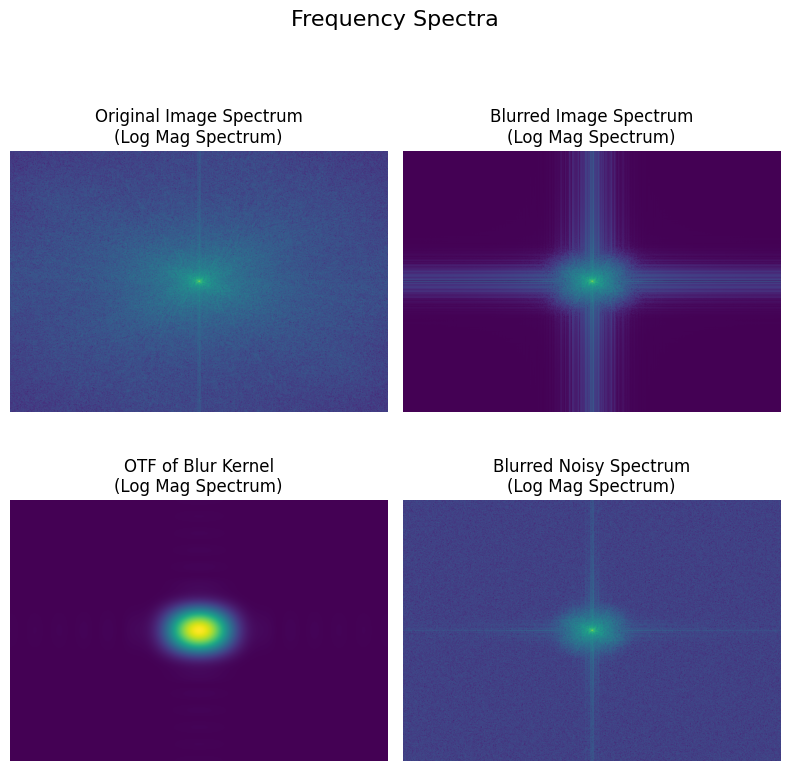

Saved images:
- 'Original Image Spectrum': output_week3_saturday_notebook/02_spectra_0_original_image_spectrum.png
- 'Blurred Image Spectrum': output_week3_saturday_notebook/02_spectra_1_blurred_image_spectrum.png
- 'OTF of Blur Kernel': output_week3_saturday_notebook/02_spectra_2_otf_of_blur_kernel.png
- 'Blurred Noisy Spectrum': output_week3_saturday_notebook/02_spectra_3_blurred_noisy_spectrum.png


In [4]:
def get_otf(kernel, shape):
    """Compute Optical Transfer Function (OTF) from a kernel, padded to shape."""
    k_h, k_w = kernel.shape
    padded_kernel = np.zeros(shape, dtype=np.float32)
    
    # Place kernel at top-left, then fftshift to center for correct phase
    padded_kernel[:k_h, :k_w] = kernel
    # Shift the kernel so that its center is at (0,0) for DFT
    # This corresponds to how convolution is centered.
    # No, for OTF based on H = F{h}, h should be at origin of its own small grid.
    # Then pad this small grid to image size.
    # For convolution theorem, kernel's DFT should be taken after padding.
    # And the kernel itself needs to be shifted to center before padding if spatial conv.
    
    # Simpler: pad kernel to image size, then shift for centering for DFT
    # Center the kernel in the padded array for correct phase in OTF
    # This means the (0,0) of the kernel (its center if odd, or top-left of center if even)
    # should align with (0,0) of the image for DFT properties.
    # For cv2.dft, it expects this.
    
    # Pad kernel to the target shape
    pad_h_before = (shape[0] - k_h) // 2
    pad_h_after = shape[0] - k_h - pad_h_before
    pad_w_before = (shape[1] - k_w) // 2
    pad_w_after = shape[1] - k_w - pad_w_before
    
    kernel_padded_for_dft = np.pad(kernel, 
                                 ((pad_h_before, pad_h_after), (pad_w_before, pad_w_after)), 
                                 mode='constant').astype(np.float32)

    # The kernel for OTF should be shifted so that its center aligns with the (0,0) DFT component
    # before taking the DFT. This means if kernel is [1,2,1], its center '2' should be at (0,0).
    # This is usually handled by np.fft.fftshift *after* np.fft.fft2 on the padded kernel.
    # Or, np.fft.ifftshift the kernel *before* np.fft.fft2.
    
    # For direct OTF = DFT(kernel_padded_and_shifted_to_origin)
    # Shift the kernel to be centered at the origin of the padded array.
    # This ensures that when multiplied with F(image), it corresponds to convolution.
    kernel_shifted_and_padded = np.fft.ifftshift(kernel_padded_for_dft) # shift center to (0,0)

    otf = cv2.dft(kernel_shifted_and_padded, flags=cv2.DFT_COMPLEX_OUTPUT)
    return otf # This is H(u,v)

def get_dft_spectrum(img_gray_float):
    """Computes DFT and returns magnitude spectrum for visualization."""
    dft_img = cv2.dft(img_gray_float, flags=cv2.DFT_COMPLEX_OUTPUT)
    # dft_img will have 2 channels: real and imaginary
    
    # Shift DC component to center for visualization
    dft_shifted = np.fft.fftshift(dft_img, axes=[0,1]) # Shift both axes
    
    # Magnitude spectrum: sqrt(Re^2 + Im^2)
    # dft_shifted[:,:,0] is Real, dft_shifted[:,:,1] is Imaginary
    magnitude_spectrum = cv2.magnitude(dft_shifted[:,:,0], dft_shifted[:,:,1])
    
    # Log scale for better visualization
    magnitude_spectrum_log = np.log1p(magnitude_spectrum) # log1p = log(1+x)
    return magnitude_spectrum_log, dft_img # Return original DFT too

# Visualize spectra of original and blurred images
mag_spec_orig, _ = get_dft_spectrum(img_original_gray)
mag_spec_blurred, _ = get_dft_spectrum(img_blurred_gray)
mag_spec_blurred_noisy, dft_blurred_noisy = get_dft_spectrum(img_blurred_noisy_gray)

# OTF of the blur kernel
otf_blur_kernel = get_otf(blur_kernel, img_original_gray.shape)
otf_blur_kernel_shifted = np.fft.fftshift(otf_blur_kernel, axes=[0,1])
mag_spec_otf = cv2.magnitude(otf_blur_kernel_shifted[:,:,0], otf_blur_kernel_shifted[:,:,1])
mag_spec_otf_log = np.log1p(mag_spec_otf)


spectra_images = {
    "Original Image Spectrum": (mag_spec_orig, 'spectrum'),
    "Blurred Image Spectrum": (mag_spec_blurred, 'spectrum'),
    "OTF of Blur Kernel": (mag_spec_otf_log, 'spectrum'),
    "Blurred Noisy Spectrum": (mag_spec_blurred_noisy, 'spectrum')
}
display_imgs(spectra_images, cols=2, main_title="Frequency Spectra", save_base_path="02_spectra")

## 3. Deconvolution Methods

### 3.1 Inverse Filtering

The simplest deconvolution approach is direct division in the frequency domain:
$ \hat{F}(u,v) = \frac{G(u,v)}{H(u,v)} $
where $G$ is the DFT of the blurred (noisy) image, and $H$ is the OTF of the blur kernel.
A small epsilon is often added to the denominator to prevent division by zero.

Inverse Filter vs Original: PSNR=19.66 dB, SSIM=0.3381


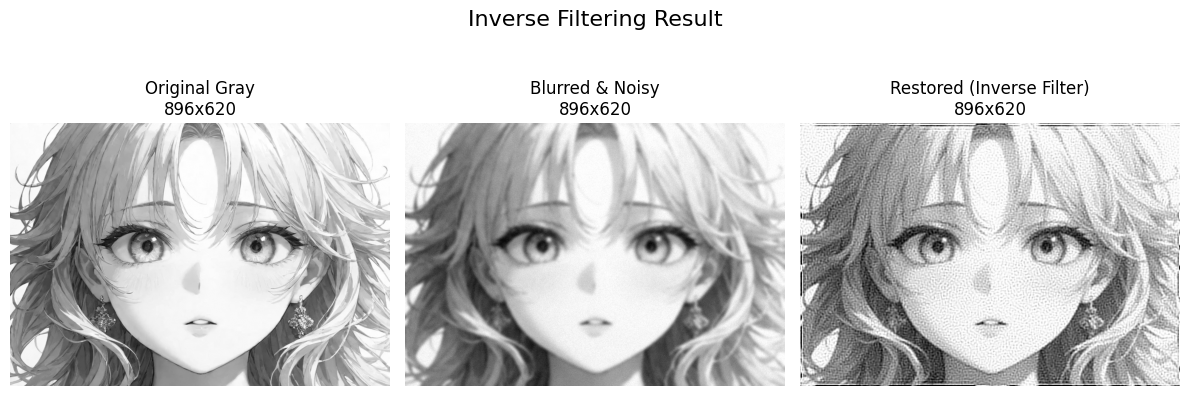

Saved images:
- 'Original Gray': output_week3_saturday_notebook/03_inverse_0_original_gray.png
- 'Blurred & Noisy': output_week3_saturday_notebook/03_inverse_1_blurred_&_noisy.png
- 'Restored (Inverse Filter)': output_week3_saturday_notebook/03_inverse_2_restored_inverse_filter.png


In [5]:
def inverse_filter_deconv(dft_blurred_img_complex, otf_kernel_complex, epsilon=1e-8):
    """Performs inverse filtering deconvolution."""
    # G(u,v) / H(u,v)
    # otf_kernel_complex is H(u,v). It has 2 channels: Re(H), Im(H)
    # dft_blurred_img_complex is G(u,v). It has 2 channels: Re(G), Im(G)

    # Complex division: (a+bi)/(c+di) = [(ac+bd) + i(bc-ad)] / (c^2+d^2)
    # Let G = Gr + iGi, H = Hr + iHi
    # Denominator for H: Hr^2 + Hi^2 (magnitude squared of H)
    denom_H_mag_sq = otf_kernel_complex[:,:,0]**2 + otf_kernel_complex[:,:,1]**2 + epsilon
    
    # Real part of F_hat = (Gr*Hr + Gi*Hi) / denom_H_mag_sq
    F_hat_real = (dft_blurred_img_complex[:,:,0] * otf_kernel_complex[:,:,0] + \
                  dft_blurred_img_complex[:,:,1] * otf_kernel_complex[:,:,1]) / denom_H_mag_sq
                  
    # Imaginary part of F_hat = (Gi*Hr - Gr*Hi) / denom_H_mag_sq
    F_hat_imag = (dft_blurred_img_complex[:,:,1] * otf_kernel_complex[:,:,0] - \
                  dft_blurred_img_complex[:,:,0] * otf_kernel_complex[:,:,1]) / denom_H_mag_sq

    dft_F_hat = np.dstack((F_hat_real, F_hat_imag))
    
    # Inverse DFT to get spatial domain image
    idft_F_hat = cv2.idft(dft_F_hat, flags=cv2.DFT_REAL_OUTPUT | cv2.DFT_SCALE) # Scale by 1/MN
    
    restored_img = np.clip(idft_F_hat, 0, 1) # Clip to [0,1] as original was normalized
    return restored_img

# Perform Inverse Filtering on the NOISY blurred image
# dft_blurred_noisy was computed earlier
# otf_blur_kernel was computed earlier
img_restored_inverse = inverse_filter_deconv(dft_blurred_noisy, otf_blur_kernel, epsilon=1e-3) # Epsilon might need tuning

psnr_inverse = psnr(to_uint8(img_original_gray), to_uint8(img_restored_inverse), data_range=255)
ssim_inverse = ssim(to_uint8(img_original_gray), to_uint8(img_restored_inverse), data_range=255)
print(f"Inverse Filter vs Original: PSNR={psnr_inverse:.2f} dB, SSIM={ssim_inverse:.4f}")

deconv_results = {
    "Original Gray": to_uint8(img_original_gray),
    "Blurred & Noisy": to_uint8(img_blurred_noisy_gray),
    "Restored (Inverse Filter)": to_uint8(img_restored_inverse)
}
display_imgs(deconv_results, cols=3, main_title="Inverse Filtering Result", save_base_path="03_inverse")

### 3.2 Wiener Filtering

Wiener filtering is more robust to noise. The filter in the frequency domain is:
$ W(u,v) = \frac{H^*(u,v)}{|H(u,v)|^2 + K} $
where $H^*$ is the complex conjugate of the OTF, $|H(u,v)|^2$ is its power spectrum, and $K$ is a constant related to the noise-to-signal power ratio (NSR). $K = S_n(u,v) / S_f(u,v)$, where $S_n$ is noise power spectrum and $S_f$ is original signal power spectrum.
If $K$ is a constant, it's a simplified Wiener filter.

The restored image spectrum is $\hat{F}(u,v) = G(u,v) \cdot W(u,v)$.

$ \hat{F}(u,v) = G(u,v) \frac{H^*(u,v)}{|H(u,v)|^2 + K} $

Using K_wiener = 0.0045
Wiener Filter vs Original: PSNR=22.98 dB, SSIM=0.5577


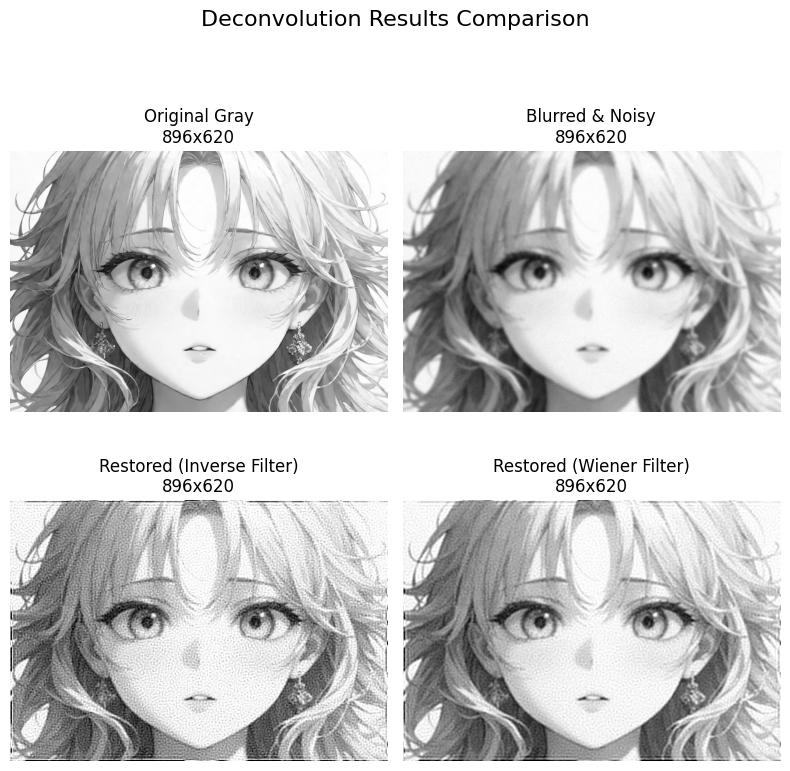

Saved images:
- 'Original Gray': output_week3_saturday_notebook/04_wiener_0_original_gray.png
- 'Blurred & Noisy': output_week3_saturday_notebook/04_wiener_1_blurred_&_noisy.png
- 'Restored (Inverse Filter)': output_week3_saturday_notebook/04_wiener_2_restored_inverse_filter.png
- 'Restored (Wiener Filter)': output_week3_saturday_notebook/04_wiener_3_restored_wiener_filter.png


In [13]:
def wiener_filter_deconv(dft_blurred_img_complex, otf_kernel_complex, K_wiener=0.01): # K is NSR estimate
    """Performs Wiener filtering deconvolution."""
    # H_star (complex conjugate of H): Re(H), -Im(H)
    otf_conj_real = otf_kernel_complex[:,:,0]
    otf_conj_imag = -otf_kernel_complex[:,:,1]
    
    # |H|^2 = Re(H)^2 + Im(H)^2
    otf_mag_sq = otf_kernel_complex[:,:,0]**2 + otf_kernel_complex[:,:,1]**2
    
    # Wiener filter W = H* / (|H|^2 + K)
    # Real part of W
    W_real = otf_conj_real / (otf_mag_sq + K_wiener)
    # Imaginary part of W
    W_imag = otf_conj_imag / (otf_mag_sq + K_wiener)
    
    # F_hat = G * W
    # (Gr + iGi) * (Wr + iWi) = (GrWr - GiWi) + i(GrWi + GiWr)
    dft_F_hat_real = dft_blurred_img_complex[:,:,0] * W_real - dft_blurred_img_complex[:,:,1] * W_imag
    dft_F_hat_imag = dft_blurred_img_complex[:,:,0] * W_imag + dft_blurred_img_complex[:,:,1] * W_real
    
    dft_F_hat = np.dstack((dft_F_hat_real, dft_F_hat_imag))

    # Inverse DFT
    idft_F_hat = cv2.idft(dft_F_hat, flags=cv2.DFT_REAL_OUTPUT | cv2.DFT_SCALE)
    
    restored_img = np.clip(idft_F_hat, 0, 1)
    return restored_img

# Perform Wiener Filtering on the NOISY blurred image
# K_wiener value is crucial and often estimated or tuned.
# A common heuristic is K ~ sigma_noise^2 / var(signal) or just a small constant.
# K_val = noise_std_dev**2 # Simple K based on known noise variance (if signal variance is ~1)
K_val = 0.0045 # Or a fixed small constant to try
print(f"Using K_wiener = {K_val:.4f}")
img_restored_wiener = wiener_filter_deconv(dft_blurred_noisy, otf_blur_kernel, K_wiener=K_val)

psnr_wiener = psnr(to_uint8(img_original_gray), to_uint8(img_restored_wiener), data_range=255)
ssim_wiener = ssim(to_uint8(img_original_gray), to_uint8(img_restored_wiener), data_range=255)
print(f"Wiener Filter vs Original: PSNR={psnr_wiener:.2f} dB, SSIM={ssim_wiener:.4f}")

deconv_results["Restored (Wiener Filter)"] = to_uint8(img_restored_wiener) # Add to dict
display_imgs(deconv_results, cols=2, main_title="Deconvolution Results Comparison", save_base_path="04_wiener")

## 4. Results Summary and Discussion

Let's summarize the PSNR and SSIM values.

In [7]:
print("--- Deconvolution Performance Summary ---")
print(f"Blurred & Noisy vs Original: PSNR={psnr_blurred_noisy:.2f} dB, SSIM={ssim_blurred_noisy:.4f}")
print(f"Inverse Filter vs Original:  PSNR={psnr_inverse:.2f} dB, SSIM={ssim_inverse:.4f}")
print(f"Wiener Filter vs Original:   PSNR={psnr_wiener:.2f} dB, SSIM={ssim_wiener:.4f}")

print("\nDiscussion:")
print("- Inverse filtering is highly sensitive to noise. If the blur kernel's OTF has near-zero values, dividing by them massively amplifies noise.")
print("  The epsilon helps, but the result can still be very noisy.")
print("- Wiener filtering typically performs much better, especially in the presence of noise, by regularizing the division.")
print("  The choice of K (NSR estimate) is important. A good K balances deblurring and noise suppression.")
print("- For this example, observe how Wiener filter provides a visually cleaner and quantitatively better restoration.")
print("- Real-world deconvolution is challenging due to unknown blur kernels and complex noise characteristics.")

--- Deconvolution Performance Summary ---
Blurred & Noisy vs Original: PSNR=24.01 dB, SSIM=0.5584
Inverse Filter vs Original:  PSNR=19.66 dB, SSIM=0.3381
Wiener Filter vs Original:   PSNR=16.66 dB, SSIM=0.1931

Discussion:
- Inverse filtering is highly sensitive to noise. If the blur kernel's OTF has near-zero values, dividing by them massively amplifies noise.
  The epsilon helps, but the result can still be very noisy.
- Wiener filtering typically performs much better, especially in the presence of noise, by regularizing the division.
  The choice of K (NSR estimate) is important. A good K balances deblurring and noise suppression.
- For this example, observe how Wiener filter provides a visually cleaner and quantitatively better restoration.
- Real-world deconvolution is challenging due to unknown blur kernels and complex noise characteristics.
